In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

le = LabelEncoder()
data_df = pd.read_csv('sequential.csv')
columns_drop = ['label','vv','Unnamed: 0']
data_df = data_df.drop(columns = columns_drop)

le_stn4contest = LabelEncoder()
le_ef_month = LabelEncoder()
le_class_interval = LabelEncoder()
le_ef_year = LabelEncoder()
le_ef_day = LabelEncoder()
le_ef_hour = LabelEncoder()
# Encode categorical columns
data_df['stn4contest'] = le_stn4contest.fit_transform(data_df['stn4contest'])
data_df['ef_month'] = le_ef_month.fit_transform(data_df['ef_month'])
data_df['ef_year'] = le_ef_month.fit_transform(data_df['ef_year'])
data_df['class_interval'] = le_class_interval.fit_transform(data_df['class_interval'])
data_df['ef_hour'] =le_ef_hour.fit_transform(data_df['ef_hour'])
data_df['ef_day'] = le_ef_day.fit_transform(data_df['ef_day'])
scaler_std = RobustScaler()
std_scale_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09'] # dh는 scale하지 말자 => 정보 손실
data_df['dh']= data_df['dh']/ 240

prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
num_agg = data_df.groupby(index_column)[prob_column].agg(['mean', 'min', 'max', 'first','std'])
num_agg.columns = ['_'.join(x) for x in num_agg.columns]
first_df = data_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
num_agg.index= first_df.index

num_agg['ef_month'] = first_df['ef_month']
num_agg['ef_hour'] = first_df['ef_hour']
num_agg['ef_day'] = first_df['ef_day']

num_agg['diff1']=num_agg['v01_first']-num_agg['v02_first']
num_agg['diff2']=num_agg['v02_first']-num_agg['v03_first']
num_agg['diff3']=num_agg['v03_first']-num_agg['v04_first']
num_agg['diff4']=num_agg['v04_first']-num_agg['v05_first']
num_agg['diff5']=num_agg['v05_first']-num_agg['v06_first']
num_agg['diff6']=num_agg['v06_first']-num_agg['v07_first']
num_agg['diff7']=num_agg['v07_first']-num_agg['v08_first']
num_agg['diff8']=num_agg['v08_first']-num_agg['v09_first']

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, f1_score
from xgboost import XGBClassifier
XGboost = XGBClassifier(random_state=42)
X = num_agg
X = X.fillna(0)
y = first_df['class_interval']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
def clf_eval(y_pred,y_test):
    cm = confusion_matrix(y_test, y_pred)
    C11 = cm[0][0]
    M = cm[1:,0].sum()
    H = sum([cm[i][i] for i in range(1,10)])
    F = sum(sum(cm)) - H - M - C11
    clf = H / (H + F + M)
    return clf

def model_evaluation(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') 
    clf = clf_eval(y_pred,y_test)
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    return clf

In [3]:
def make_submission(model):
    test_df = pd.read_csv('rainfall_test.csv')
    test_df.columns = test_df.columns.str.replace('rainfall_test.', '', regex=False)
    data_df = pd.read_csv('sequential.csv')
    columns_drop = ['label','vv','Unnamed: 0']
    data_df = data_df.drop(columns = columns_drop)
    answer_df = test_df[data_df.columns]
    le_ef_month = LabelEncoder()
    answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
    answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
    answer_df['ef_day'] = le_ef_month.fit_transform(answer_df['ef_day'])
    answer_df['ef_hour'] = le_ef_month.fit_transform(answer_df['ef_hour'])
    answer_df['v01'] = answer_df['v01']/100
    answer_df['v02'] = answer_df['v02']/100
    answer_df['v03'] = answer_df['v03']/100
    answer_df['v04'] = answer_df['v04']/100
    answer_df['v05'] = answer_df['v05']/100
    answer_df['v06'] = answer_df['v06']/100
    answer_df['v07'] = answer_df['v07']/100
    answer_df['v08'] = answer_df['v08']/100
    answer_df['v09'] = answer_df['v09']/100
    prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
    index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
    answer_agg = answer_df.groupby(index_column)[prob_column].agg(['mean', 'std', 'min', 'max', 'first'])
    answer_agg.columns = ['_'.join(x) for x in answer_agg.columns]
    answer_first = answer_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
    answer_agg.index= answer_first.index
    answer_agg = answer_agg.fillna(0)
    answer_agg['diff1']=answer_agg['v01_first']-answer_agg['v02_first']
    answer_agg['diff2']=answer_agg['v02_first']-answer_agg['v03_first']
    answer_agg['diff3']=answer_agg['v03_first']-answer_agg['v04_first']
    answer_agg['diff4']=answer_agg['v04_first']-answer_agg['v05_first']
    answer_agg['diff5']=answer_agg['v05_first']-answer_agg['v06_first']
    answer_agg['diff6']=answer_agg['v06_first']-answer_agg['v07_first']
    answer_agg['diff7']=answer_agg['v07_first']-answer_agg['v08_first']
    answer_agg['diff8']=answer_agg['v08_first']-answer_agg['v09_first']
    answer_agg['ef_month'] = answer_first['ef_month']
    answer_agg['ef_day'] = answer_first['ef_day']
    answer_agg['ef_hour'] = answer_first['ef_hour']
    answer_agg = answer_agg[X.columns]
    answer = model.predict(answer_agg)
    answer_agg['class_interval']=answer
    answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])
    answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')
    test_df['class_interval']=answer_df['class_interval']
    return test_df

In [4]:
from catboost import CatBoostClassifier
best_cat_params = {'iterations': 455, 'depth': 10, 'learning_rate': 0.22728295299413886,'l2_leaf_reg': 20}

Learning rate set to 0.189986
0:	learn: 1.2068068	total: 948ms	remaining: 7m 10s
1:	learn: 1.0064088	total: 1.82s	remaining: 6m 51s
2:	learn: 0.8791081	total: 2.63s	remaining: 6m 36s
3:	learn: 0.7910948	total: 3.41s	remaining: 6m 24s
4:	learn: 0.7251827	total: 4.18s	remaining: 6m 16s
5:	learn: 0.6757746	total: 4.96s	remaining: 6m 11s
6:	learn: 0.6391088	total: 5.74s	remaining: 6m 7s
7:	learn: 0.6089120	total: 6.6s	remaining: 6m 9s
8:	learn: 0.5847036	total: 7.36s	remaining: 6m 4s
9:	learn: 0.5653810	total: 8.2s	remaining: 6m 4s
10:	learn: 0.5486679	total: 9.04s	remaining: 6m 4s
11:	learn: 0.5345943	total: 9.96s	remaining: 6m 7s
12:	learn: 0.5226277	total: 10.8s	remaining: 6m 6s
13:	learn: 0.5129933	total: 11.6s	remaining: 6m 6s
14:	learn: 0.5041980	total: 12.4s	remaining: 6m 4s
15:	learn: 0.4978624	total: 13.2s	remaining: 6m 1s
16:	learn: 0.4913867	total: 14s	remaining: 6m
17:	learn: 0.4863475	total: 14.8s	remaining: 5m 58s
18:	learn: 0.4815330	total: 15.6s	remaining: 5m 57s
19:	learn:

<Axes: >

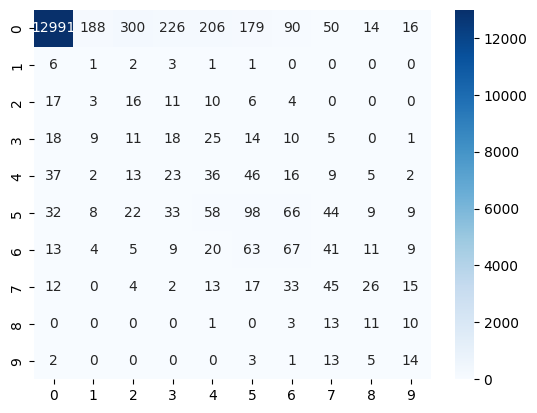

In [5]:
# 기본 catboost
cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'])
cat.fit(X_train,y_train)
y_pred = cat.predict(X_test)
model_evaluation(y_pred, y_test)

cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [10]:
# K fold 진행

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train,test in skf.split(X,y):
    X_train, X_test = X.iloc[train], X.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]
    cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'])
    cat.fit(X_train,y_train)
    y_pred = cat.predict(X_test)
    print(clf_eval(y_pred, y_test))

Learning rate set to 0.189986
0:	learn: 1.2069260	total: 707ms	remaining: 5m 21s
1:	learn: 1.0077110	total: 1.47s	remaining: 5m 32s
2:	learn: 0.8804021	total: 2.2s	remaining: 5m 31s
3:	learn: 0.7909515	total: 2.87s	remaining: 5m 23s
4:	learn: 0.7246822	total: 3.58s	remaining: 5m 22s
5:	learn: 0.6753855	total: 4.33s	remaining: 5m 24s
6:	learn: 0.6381620	total: 5.07s	remaining: 5m 24s
7:	learn: 0.6078661	total: 5.77s	remaining: 5m 22s
8:	learn: 0.5828031	total: 6.42s	remaining: 5m 17s
9:	learn: 0.5651201	total: 7.04s	remaining: 5m 13s
10:	learn: 0.5478993	total: 7.74s	remaining: 5m 12s
11:	learn: 0.5342754	total: 8.44s	remaining: 5m 11s
12:	learn: 0.5225693	total: 9.15s	remaining: 5m 11s
13:	learn: 0.5141890	total: 9.82s	remaining: 5m 9s
14:	learn: 0.5058268	total: 10.5s	remaining: 5m 8s
15:	learn: 0.4981082	total: 11.2s	remaining: 5m 6s
16:	learn: 0.4917095	total: 11.8s	remaining: 5m 4s
17:	learn: 0.4867766	total: 12.4s	remaining: 5m 1s
18:	learn: 0.4807594	total: 13s	remaining: 4m 59s


Accuracy: 0.8571336429308566
Precision: 0.8056073448732329
Recall: 0.8571336429308566


0.12415974693554764

0:	learn: 2.0655596	total: 3.17s	remaining: 24m
1:	learn: 1.9428666	total: 6.44s	remaining: 24m 19s
2:	learn: 1.8655194	total: 9.95s	remaining: 24m 59s
3:	learn: 1.8045863	total: 13.1s	remaining: 24m 36s
4:	learn: 1.7542015	total: 16.3s	remaining: 24m 25s
5:	learn: 1.7066176	total: 19.6s	remaining: 24m 25s
6:	learn: 1.6700268	total: 22.8s	remaining: 24m 16s
7:	learn: 1.6295668	total: 26.1s	remaining: 24m 16s
8:	learn: 1.5954665	total: 29.5s	remaining: 24m 23s
9:	learn: 1.5624263	total: 33.1s	remaining: 24m 33s
10:	learn: 1.5278757	total: 36.6s	remaining: 24m 38s
11:	learn: 1.5092138	total: 39.6s	remaining: 24m 21s
12:	learn: 1.4909668	total: 42.7s	remaining: 24m 11s
13:	learn: 1.4695976	total: 46s	remaining: 24m 9s
14:	learn: 1.4477969	total: 49.3s	remaining: 24m 7s
15:	learn: 1.4275996	total: 52.7s	remaining: 24m 5s
16:	learn: 1.4015979	total: 56.4s	remaining: 24m 13s
17:	learn: 1.3893306	total: 59.4s	remaining: 24m 2s
18:	learn: 1.3794304	total: 1m 2s	remaining: 23m 50s
19:	learn: 1.

<Axes: >

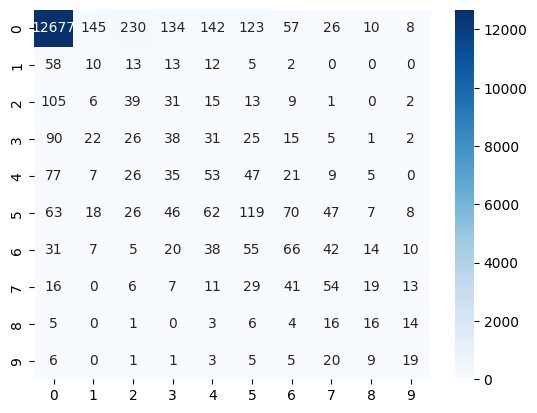

In [6]:
# SMOTE catboost, regularzize =20
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
cat_SMOTE = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=best_cat_params['l2_leaf_reg'])
cat_SMOTE.fit(X_train_resampled, y_train_resampled)
y_pred = cat_SMOTE.predict(X_test)
model_evaluation(y_pred, y_test)

cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

0:	learn: 2.0582149	total: 3.49s	remaining: 26m 23s
1:	learn: 1.9403821	total: 7.03s	remaining: 26m 31s
2:	learn: 1.8598197	total: 10.4s	remaining: 26m 11s
3:	learn: 1.7958903	total: 13.8s	remaining: 25m 56s
4:	learn: 1.7483527	total: 17.2s	remaining: 25m 47s
5:	learn: 1.6945995	total: 21s	remaining: 26m 15s
6:	learn: 1.6449402	total: 25s	remaining: 26m 40s
7:	learn: 1.6062510	total: 28.8s	remaining: 26m 47s
8:	learn: 1.5739838	total: 32.4s	remaining: 26m 47s
9:	learn: 1.5465054	total: 36.2s	remaining: 26m 48s
10:	learn: 1.5048195	total: 40.7s	remaining: 27m 21s
11:	learn: 1.4746423	total: 44.6s	remaining: 27m 27s
12:	learn: 1.4579606	total: 48.1s	remaining: 27m 15s
13:	learn: 1.4295160	total: 51.9s	remaining: 27m 15s
14:	learn: 1.4149344	total: 55.3s	remaining: 27m 2s
15:	learn: 1.3950197	total: 58.9s	remaining: 26m 55s
16:	learn: 1.3813690	total: 1m 2s	remaining: 26m 44s
17:	learn: 1.3494503	total: 1m 6s	remaining: 26m 54s
18:	learn: 1.3356787	total: 1m 9s	remaining: 26m 44s
19:	lear

<Axes: >

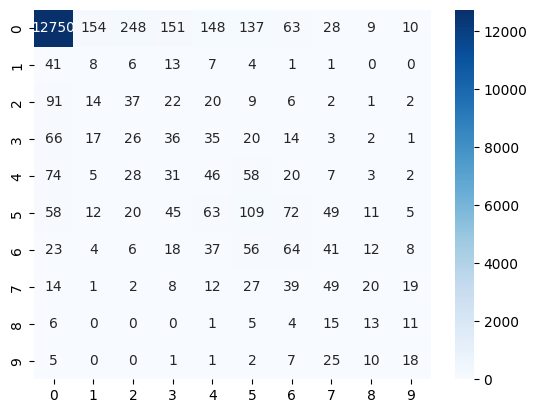

In [7]:
# SMOTE catboost, reg = 10
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
cat_SMOTE_10 = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=10)
cat_SMOTE_10.fit(X_train_resampled, y_train_resampled)
y_pred = cat_SMOTE_10.predict(X_test)
model_evaluation(y_pred, y_test)

cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [22]:
# SMOTE catboost regularization hyperparameter tuning
'''
reg = 20 is best 
'''
from imblearn.over_sampling import SMOTE
import optuna

def objective(trial):
    smote = SMOTE(random_state=42)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 5, 30)
    cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg = l2_leaf_reg)
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    # Fit the model
    cat.fit(X_train_resampled, y_train_resampled)
    
    # Predict the validation set results
    y_pred = cat.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-22 20:28:34,692] A new study created in memory with name: no-name-9415475c-1206-4844-9e7d-81e3dbea7b81


0:	learn: 2.0694722	total: 4.34s	remaining: 32m 51s
1:	learn: 1.9537655	total: 8.96s	remaining: 33m 50s
2:	learn: 1.8775493	total: 13.9s	remaining: 34m 59s
3:	learn: 1.8168331	total: 18.2s	remaining: 34m 9s
4:	learn: 1.7712089	total: 22.4s	remaining: 33m 32s
5:	learn: 1.7190481	total: 26.5s	remaining: 33m 6s
6:	learn: 1.6791633	total: 30.8s	remaining: 32m 53s
7:	learn: 1.6468993	total: 34.6s	remaining: 32m 15s
8:	learn: 1.6159579	total: 38.4s	remaining: 31m 43s
9:	learn: 1.5879916	total: 42.4s	remaining: 31m 27s
10:	learn: 1.5529360	total: 47.2s	remaining: 31m 44s
11:	learn: 1.5285726	total: 51s	remaining: 31m 24s
12:	learn: 1.5083543	total: 54.7s	remaining: 30m 58s
13:	learn: 1.4885600	total: 58.4s	remaining: 30m 40s
14:	learn: 1.4745397	total: 1m 1s	remaining: 30m 16s
15:	learn: 1.4435705	total: 1m 6s	remaining: 30m 17s
16:	learn: 1.4227975	total: 1m 9s	remaining: 30m
17:	learn: 1.4087182	total: 1m 13s	remaining: 29m 37s
18:	learn: 1.3872863	total: 1m 16s	remaining: 29m 25s
19:	learn

[I 2024-06-22 20:54:28,157] Trial 0 finished with value: 0.13944502985598875 and parameters: {'l2_leaf_reg': 26}. Best is trial 0 with value: 0.13944502985598875.


0:	learn: 2.0675523	total: 3.26s	remaining: 24m 40s
1:	learn: 1.9454561	total: 6.75s	remaining: 25m 29s
2:	learn: 1.8682732	total: 9.93s	remaining: 24m 56s
3:	learn: 1.8075470	total: 13.2s	remaining: 24m 43s
4:	learn: 1.7573667	total: 16.4s	remaining: 24m 39s
5:	learn: 1.7103084	total: 19.9s	remaining: 24m 46s
6:	learn: 1.6689043	total: 23.4s	remaining: 24m 59s
7:	learn: 1.6417171	total: 26.6s	remaining: 24m 45s
8:	learn: 1.6058696	total: 30s	remaining: 24m 48s
9:	learn: 1.5776284	total: 33.4s	remaining: 24m 44s
10:	learn: 1.5426917	total: 37.1s	remaining: 24m 59s
11:	learn: 1.5130887	total: 40.7s	remaining: 25m 2s
12:	learn: 1.4954100	total: 44s	remaining: 24m 56s
13:	learn: 1.4787749	total: 47.1s	remaining: 24m 43s
14:	learn: 1.4669339	total: 50.3s	remaining: 24m 34s
15:	learn: 1.4502799	total: 53.4s	remaining: 24m 25s
16:	learn: 1.4362427	total: 56.6s	remaining: 24m 18s
17:	learn: 1.4201395	total: 1m	remaining: 24m 19s
18:	learn: 1.4027275	total: 1m 3s	remaining: 24m 20s
19:	learn: 

[I 2024-06-22 21:19:35,612] Trial 1 finished with value: 0.1431076815152578 and parameters: {'l2_leaf_reg': 23}. Best is trial 1 with value: 0.1431076815152578.


0:	learn: 2.0634832	total: 3.37s	remaining: 25m 30s
1:	learn: 1.9401570	total: 6.86s	remaining: 25m 53s
2:	learn: 1.8626174	total: 10s	remaining: 25m 9s
3:	learn: 1.7999040	total: 13.2s	remaining: 24m 45s
4:	learn: 1.7457614	total: 16.3s	remaining: 24m 29s
5:	learn: 1.6991147	total: 19.7s	remaining: 24m 32s
6:	learn: 1.6663641	total: 22.7s	remaining: 24m 14s
7:	learn: 1.6338834	total: 25.9s	remaining: 24m 9s
8:	learn: 1.6075138	total: 29.2s	remaining: 24m 5s
9:	learn: 1.5768525	total: 32.5s	remaining: 24m 5s
10:	learn: 1.5348745	total: 36.4s	remaining: 24m 27s
11:	learn: 1.5064249	total: 39.9s	remaining: 24m 31s
12:	learn: 1.4852349	total: 43.1s	remaining: 24m 25s
13:	learn: 1.4604314	total: 46.6s	remaining: 24m 26s
14:	learn: 1.4447998	total: 49.7s	remaining: 24m 17s
15:	learn: 1.4266973	total: 52.9s	remaining: 24m 11s
16:	learn: 1.4027781	total: 56.6s	remaining: 24m 17s
17:	learn: 1.3871840	total: 59.9s	remaining: 24m 13s
18:	learn: 1.3635391	total: 1m 3s	remaining: 24m 14s
19:	learn

[I 2024-06-22 21:44:51,415] Trial 2 finished with value: 0.14295900178253118 and parameters: {'l2_leaf_reg': 17}. Best is trial 1 with value: 0.1431076815152578.


0:	learn: 2.0573981	total: 3.54s	remaining: 26m 46s
1:	learn: 1.9392089	total: 7.29s	remaining: 27m 32s
2:	learn: 1.8585042	total: 10.6s	remaining: 26m 40s
3:	learn: 1.7944561	total: 13.9s	remaining: 26m 6s
4:	learn: 1.7468664	total: 16.9s	remaining: 25m 24s
5:	learn: 1.6912693	total: 20.6s	remaining: 25m 38s
6:	learn: 1.6413383	total: 24s	remaining: 25m 37s
7:	learn: 1.6060467	total: 27.3s	remaining: 25m 25s
8:	learn: 1.5744300	total: 30.5s	remaining: 25m 12s
9:	learn: 1.5456904	total: 33.8s	remaining: 25m 4s
10:	learn: 1.5032754	total: 37.9s	remaining: 25m 28s
11:	learn: 1.4780213	total: 41.1s	remaining: 25m 17s
12:	learn: 1.4522023	total: 44.8s	remaining: 25m 23s
13:	learn: 1.4227967	total: 48.5s	remaining: 25m 26s
14:	learn: 1.3940425	total: 52.1s	remaining: 25m 28s
15:	learn: 1.3697614	total: 55.6s	remaining: 25m 26s
16:	learn: 1.3376453	total: 59.7s	remaining: 25m 37s
17:	learn: 1.3229275	total: 1m 2s	remaining: 25m 26s
18:	learn: 1.3125829	total: 1m 5s	remaining: 25m 11s
19:	lea

[I 2024-06-22 22:12:29,986] Trial 3 finished with value: 0.14347826086956522 and parameters: {'l2_leaf_reg': 9}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0573981	total: 3.61s	remaining: 27m 20s
1:	learn: 1.9392089	total: 7.54s	remaining: 28m 27s
2:	learn: 1.8585042	total: 11.4s	remaining: 28m 42s
3:	learn: 1.7944561	total: 15.2s	remaining: 28m 28s
4:	learn: 1.7468664	total: 18.9s	remaining: 28m 22s
5:	learn: 1.6912693	total: 23.5s	remaining: 29m 21s
6:	learn: 1.6413383	total: 27.9s	remaining: 29m 43s
7:	learn: 1.6060467	total: 31.7s	remaining: 29m 33s
8:	learn: 1.5744300	total: 35.5s	remaining: 29m 17s
9:	learn: 1.5456904	total: 39.4s	remaining: 29m 11s
10:	learn: 1.5032754	total: 43.9s	remaining: 29m 32s
11:	learn: 1.4780213	total: 47.9s	remaining: 29m 27s
12:	learn: 1.4522023	total: 51.5s	remaining: 29m 12s
13:	learn: 1.4227967	total: 55.2s	remaining: 29m
14:	learn: 1.3940425	total: 58.8s	remaining: 28m 43s
15:	learn: 1.3697614	total: 1m 2s	remaining: 28m 40s
16:	learn: 1.3376453	total: 1m 7s	remaining: 29m 2s
17:	learn: 1.3229275	total: 1m 11s	remaining: 29m 7s
18:	learn: 1.3125829	total: 1m 16s	remaining: 29m 13s
19:	lea

[I 2024-06-22 22:42:05,393] Trial 4 finished with value: 0.14347826086956522 and parameters: {'l2_leaf_reg': 9}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0613082	total: 3.81s	remaining: 28m 50s
1:	learn: 1.9447720	total: 7.79s	remaining: 29m 24s
2:	learn: 1.8647080	total: 11.4s	remaining: 28m 35s
3:	learn: 1.8011494	total: 14.9s	remaining: 27m 55s
4:	learn: 1.7537811	total: 18.6s	remaining: 27m 55s
5:	learn: 1.7013274	total: 22.7s	remaining: 28m 16s
6:	learn: 1.6531313	total: 26.9s	remaining: 28m 41s
7:	learn: 1.6150194	total: 30.7s	remaining: 28m 37s
8:	learn: 1.5832323	total: 34.6s	remaining: 28m 36s
9:	learn: 1.5524908	total: 38.4s	remaining: 28m 27s
10:	learn: 1.5138170	total: 42.9s	remaining: 28m 53s
11:	learn: 1.4895181	total: 46.7s	remaining: 28m 45s
12:	learn: 1.4737417	total: 50.2s	remaining: 28m 27s
13:	learn: 1.4422263	total: 54.6s	remaining: 28m 41s
14:	learn: 1.4201032	total: 58.6s	remaining: 28m 40s
15:	learn: 1.4073552	total: 1m 2s	remaining: 28m 23s
16:	learn: 1.3945752	total: 1m 5s	remaining: 28m 8s
17:	learn: 1.3809288	total: 1m 9s	remaining: 27m 56s
18:	learn: 1.3565421	total: 1m 13s	remaining: 28m 12s
19:

[I 2024-06-22 23:09:52,784] Trial 5 finished with value: 0.14012278801011196 and parameters: {'l2_leaf_reg': 14}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0700974	total: 3.15s	remaining: 23m 51s
1:	learn: 1.9545313	total: 6.77s	remaining: 25m 33s
2:	learn: 1.8783770	total: 10.2s	remaining: 25m 43s
3:	learn: 1.8176894	total: 13.4s	remaining: 25m 12s
4:	learn: 1.7720814	total: 16.5s	remaining: 24m 43s
5:	learn: 1.7201095	total: 20s	remaining: 24m 54s
6:	learn: 1.6803857	total: 23.5s	remaining: 25m 4s
7:	learn: 1.6482114	total: 26.8s	remaining: 24m 56s
8:	learn: 1.6173413	total: 30s	remaining: 24m 48s
9:	learn: 1.5894705	total: 33.7s	remaining: 25m
10:	learn: 1.5546238	total: 37.4s	remaining: 25m 10s
11:	learn: 1.5304077	total: 40.9s	remaining: 25m 8s
12:	learn: 1.5102771	total: 44s	remaining: 24m 56s
13:	learn: 1.4905619	total: 47.4s	remaining: 24m 53s
14:	learn: 1.4766076	total: 50.7s	remaining: 24m 46s
15:	learn: 1.4458593	total: 55.1s	remaining: 25m 11s
16:	learn: 1.4251796	total: 58.5s	remaining: 25m 7s
17:	learn: 1.4111452	total: 1m 1s	remaining: 24m 59s
18:	learn: 1.3898478	total: 1m 5s	remaining: 25m 3s
19:	learn: 1.3781

[I 2024-06-22 23:35:46,201] Trial 6 finished with value: 0.1374125874125874 and parameters: {'l2_leaf_reg': 27}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0582149	total: 3.28s	remaining: 24m 47s
1:	learn: 1.9403821	total: 6.63s	remaining: 25m 2s
2:	learn: 1.8598197	total: 9.96s	remaining: 25m
3:	learn: 1.7958903	total: 13.1s	remaining: 24m 32s
4:	learn: 1.7483527	total: 16.4s	remaining: 24m 32s
5:	learn: 1.6945995	total: 20s	remaining: 24m 56s
6:	learn: 1.6449402	total: 23.9s	remaining: 25m 31s
7:	learn: 1.6062510	total: 27.3s	remaining: 25m 26s
8:	learn: 1.5739838	total: 30.6s	remaining: 25m 15s
9:	learn: 1.5465054	total: 33.9s	remaining: 25m 6s
10:	learn: 1.5048195	total: 37.7s	remaining: 25m 22s
11:	learn: 1.4746423	total: 41.3s	remaining: 25m 23s
12:	learn: 1.4579606	total: 44.5s	remaining: 25m 11s
13:	learn: 1.4295160	total: 48.1s	remaining: 25m 14s
14:	learn: 1.4149344	total: 51.2s	remaining: 25m 2s
15:	learn: 1.3950197	total: 54.6s	remaining: 24m 58s
16:	learn: 1.3813690	total: 57.9s	remaining: 24m 50s
17:	learn: 1.3494503	total: 1m 2s	remaining: 25m 5s
18:	learn: 1.3356787	total: 1m 5s	remaining: 24m 56s
19:	learn: 1.

[I 2024-06-23 00:01:35,794] Trial 7 finished with value: 0.13793103448275862 and parameters: {'l2_leaf_reg': 10}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0538795	total: 3.16s	remaining: 23m 56s
1:	learn: 1.9340774	total: 6.58s	remaining: 24m 49s
2:	learn: 1.8526993	total: 9.65s	remaining: 24m 14s
3:	learn: 1.7878693	total: 12.9s	remaining: 24m 14s
4:	learn: 1.7365710	total: 16.2s	remaining: 24m 15s
5:	learn: 1.7007526	total: 19.4s	remaining: 24m 11s
6:	learn: 1.6576135	total: 22.8s	remaining: 24m 18s
7:	learn: 1.6179846	total: 26.4s	remaining: 24m 35s
8:	learn: 1.5918890	total: 29.4s	remaining: 24m 18s
9:	learn: 1.5498734	total: 33.1s	remaining: 24m 34s
10:	learn: 1.5214102	total: 36.5s	remaining: 24m 35s
11:	learn: 1.4994290	total: 39.6s	remaining: 24m 23s
12:	learn: 1.4717286	total: 43.1s	remaining: 24m 26s
13:	learn: 1.4523424	total: 46.5s	remaining: 24m 23s
14:	learn: 1.4148734	total: 50.6s	remaining: 24m 45s
15:	learn: 1.3843553	total: 54.5s	remaining: 24m 55s
16:	learn: 1.3547734	total: 58.1s	remaining: 24m 57s
17:	learn: 1.3435273	total: 1m 1s	remaining: 24m 45s
18:	learn: 1.3316055	total: 1m 4s	remaining: 24m 38s
19:

[I 2024-06-23 00:27:31,098] Trial 8 finished with value: 0.13486842105263158 and parameters: {'l2_leaf_reg': 5}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0613082	total: 3.13s	remaining: 23m 42s
1:	learn: 1.9447720	total: 6.48s	remaining: 24m 27s
2:	learn: 1.8647080	total: 9.88s	remaining: 24m 48s
3:	learn: 1.8011494	total: 13.1s	remaining: 24m 39s
4:	learn: 1.7537811	total: 16.3s	remaining: 24m 24s
5:	learn: 1.7013274	total: 20.1s	remaining: 25m 2s
6:	learn: 1.6531313	total: 23.8s	remaining: 25m 23s
7:	learn: 1.6150194	total: 27.3s	remaining: 25m 22s
8:	learn: 1.5832323	total: 30.6s	remaining: 25m 17s
9:	learn: 1.5524908	total: 34.1s	remaining: 25m 16s
10:	learn: 1.5138170	total: 38s	remaining: 25m 34s
11:	learn: 1.4895181	total: 41.5s	remaining: 25m 32s
12:	learn: 1.4737417	total: 44.6s	remaining: 25m 16s
13:	learn: 1.4422263	total: 48.4s	remaining: 25m 25s
14:	learn: 1.4201032	total: 52s	remaining: 25m 25s
15:	learn: 1.4073552	total: 55s	remaining: 25m 9s
16:	learn: 1.3945752	total: 58.4s	remaining: 25m 4s
17:	learn: 1.3809288	total: 1m 1s	remaining: 24m 55s
18:	learn: 1.3565421	total: 1m 5s	remaining: 24m 55s
19:	learn: 1

[I 2024-06-23 00:53:14,806] Trial 9 finished with value: 0.14012278801011196 and parameters: {'l2_leaf_reg': 14}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0538795	total: 3.16s	remaining: 23m 52s
1:	learn: 1.9340774	total: 6.59s	remaining: 24m 53s
2:	learn: 1.8526993	total: 9.71s	remaining: 24m 23s
3:	learn: 1.7878693	total: 12.9s	remaining: 24m 16s
4:	learn: 1.7365710	total: 16s	remaining: 23m 58s
5:	learn: 1.7007526	total: 19.1s	remaining: 23m 51s
6:	learn: 1.6576135	total: 22.6s	remaining: 24m 4s
7:	learn: 1.6179846	total: 25.9s	remaining: 24m 8s
8:	learn: 1.5918890	total: 29.2s	remaining: 24m 7s
9:	learn: 1.5498734	total: 32.8s	remaining: 24m 20s
10:	learn: 1.5214102	total: 36.3s	remaining: 24m 24s
11:	learn: 1.4994290	total: 39.4s	remaining: 24m 14s
12:	learn: 1.4717286	total: 42.9s	remaining: 24m 17s
13:	learn: 1.4523424	total: 46.3s	remaining: 24m 19s
14:	learn: 1.4148734	total: 50.5s	remaining: 24m 41s
15:	learn: 1.3843553	total: 54.6s	remaining: 24m 57s
16:	learn: 1.3547734	total: 58.4s	remaining: 25m 5s
17:	learn: 1.3435273	total: 1m 1s	remaining: 24m 52s
18:	learn: 1.3316055	total: 1m 4s	remaining: 24m 50s
19:	learn

[I 2024-06-23 01:19:11,115] Trial 10 finished with value: 0.13486842105263158 and parameters: {'l2_leaf_reg': 5}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0582149	total: 3.28s	remaining: 24m 50s
1:	learn: 1.9403821	total: 6.99s	remaining: 26m 22s
2:	learn: 1.8598197	total: 10.3s	remaining: 25m 53s
3:	learn: 1.7958903	total: 13.5s	remaining: 25m 24s
4:	learn: 1.7483527	total: 16.6s	remaining: 24m 49s
5:	learn: 1.6945995	total: 20.1s	remaining: 25m 7s
6:	learn: 1.6449402	total: 23.8s	remaining: 25m 20s
7:	learn: 1.6062510	total: 27.2s	remaining: 25m 19s
8:	learn: 1.5739838	total: 30.5s	remaining: 25m 13s
9:	learn: 1.5465054	total: 33.7s	remaining: 25m 1s
10:	learn: 1.5048195	total: 37.9s	remaining: 25m 29s
11:	learn: 1.4746423	total: 41.4s	remaining: 25m 29s
12:	learn: 1.4579606	total: 44.6s	remaining: 25m 16s
13:	learn: 1.4295160	total: 48.3s	remaining: 25m 21s
14:	learn: 1.4149344	total: 51.4s	remaining: 25m 7s
15:	learn: 1.3950197	total: 54.9s	remaining: 25m 5s
16:	learn: 1.3813690	total: 58s	remaining: 24m 54s
17:	learn: 1.3494503	total: 1m 1s	remaining: 25m 4s
18:	learn: 1.3356787	total: 1m 5s	remaining: 24m 56s
19:	learn:

[I 2024-06-23 01:45:00,491] Trial 11 finished with value: 0.13793103448275862 and parameters: {'l2_leaf_reg': 10}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0582149	total: 3.12s	remaining: 23m 36s
1:	learn: 1.9403821	total: 6.81s	remaining: 25m 42s
2:	learn: 1.8598197	total: 10.1s	remaining: 25m 16s
3:	learn: 1.7958903	total: 13.2s	remaining: 24m 45s
4:	learn: 1.7483527	total: 16.5s	remaining: 24m 48s
5:	learn: 1.6945995	total: 20.1s	remaining: 25m 6s
6:	learn: 1.6449402	total: 24s	remaining: 25m 34s
7:	learn: 1.6062510	total: 27.4s	remaining: 25m 32s
8:	learn: 1.5739838	total: 30.8s	remaining: 25m 28s
9:	learn: 1.5465054	total: 34.2s	remaining: 25m 20s
10:	learn: 1.5048195	total: 38.3s	remaining: 25m 46s
11:	learn: 1.4746423	total: 42.2s	remaining: 25m 59s
12:	learn: 1.4579606	total: 45.5s	remaining: 25m 46s
13:	learn: 1.4295160	total: 49.3s	remaining: 25m 52s
14:	learn: 1.4149344	total: 52.5s	remaining: 25m 39s
15:	learn: 1.3950197	total: 56s	remaining: 25m 35s
16:	learn: 1.3813690	total: 59.1s	remaining: 25m 23s
17:	learn: 1.3494503	total: 1m 3s	remaining: 25m 32s
18:	learn: 1.3356787	total: 1m 6s	remaining: 25m 29s
19:	lear

[I 2024-06-23 02:10:52,629] Trial 12 finished with value: 0.13793103448275862 and parameters: {'l2_leaf_reg': 10}. Best is trial 3 with value: 0.14347826086956522.


0:	learn: 2.0662325	total: 3.35s	remaining: 25m 20s
1:	learn: 1.9437421	total: 7s	remaining: 26m 25s
2:	learn: 1.8664525	total: 10.8s	remaining: 27m 4s
3:	learn: 1.8055923	total: 14.1s	remaining: 26m 29s
4:	learn: 1.7552780	total: 17.5s	remaining: 26m 10s
5:	learn: 1.7078763	total: 21s	remaining: 26m 9s
6:	learn: 1.6713456	total: 24.3s	remaining: 25m 55s
7:	learn: 1.6310557	total: 27.9s	remaining: 25m 58s
8:	learn: 1.5971112	total: 31.5s	remaining: 25m 59s
9:	learn: 1.5642742	total: 35.3s	remaining: 26m 10s
10:	learn: 1.5299065	total: 39s	remaining: 26m 12s
11:	learn: 1.5113015	total: 42.3s	remaining: 26m 1s
12:	learn: 1.4931074	total: 45.5s	remaining: 25m 48s
13:	learn: 1.4719150	total: 48.9s	remaining: 25m 41s
14:	learn: 1.4501922	total: 52.4s	remaining: 25m 38s
15:	learn: 1.4301840	total: 55.9s	remaining: 25m 33s
16:	learn: 1.4044289	total: 59.9s	remaining: 25m 43s
17:	learn: 1.3922168	total: 1m 3s	remaining: 25m 32s
18:	learn: 1.3823432	total: 1m 6s	remaining: 25m 20s
19:	learn: 1.

[I 2024-06-23 02:36:40,296] Trial 13 finished with value: 0.14453961456102785 and parameters: {'l2_leaf_reg': 21}. Best is trial 13 with value: 0.14453961456102785.


0:	learn: 2.0675523	total: 3.13s	remaining: 23m 43s
1:	learn: 1.9454561	total: 6.42s	remaining: 24m 13s
2:	learn: 1.8682732	total: 9.85s	remaining: 24m 44s
3:	learn: 1.8075470	total: 13s	remaining: 24m 25s
4:	learn: 1.7573667	total: 16.3s	remaining: 24m 27s
5:	learn: 1.7103084	total: 19.6s	remaining: 24m 28s
6:	learn: 1.6689043	total: 23.2s	remaining: 24m 45s
7:	learn: 1.6417171	total: 26.3s	remaining: 24m 27s
8:	learn: 1.6058696	total: 29.7s	remaining: 24m 33s
9:	learn: 1.5776284	total: 33.3s	remaining: 24m 41s
10:	learn: 1.5426917	total: 37.3s	remaining: 25m 4s
11:	learn: 1.5130887	total: 41.1s	remaining: 25m 15s
12:	learn: 1.4954100	total: 44.6s	remaining: 25m 15s
13:	learn: 1.4787749	total: 47.7s	remaining: 25m 1s
14:	learn: 1.4669339	total: 50.8s	remaining: 24m 50s
15:	learn: 1.4502799	total: 54s	remaining: 24m 40s
16:	learn: 1.4362427	total: 57.2s	remaining: 24m 34s
17:	learn: 1.4201395	total: 1m	remaining: 24m 28s
18:	learn: 1.4027275	total: 1m 4s	remaining: 24m 33s
19:	learn: 1

[I 2024-06-23 03:02:29,267] Trial 14 finished with value: 0.1431076815152578 and parameters: {'l2_leaf_reg': 23}. Best is trial 13 with value: 0.14453961456102785.


0:	learn: 2.0655596	total: 3.09s	remaining: 23m 23s
1:	learn: 1.9428666	total: 6.42s	remaining: 24m 15s
2:	learn: 1.8655194	total: 9.6s	remaining: 24m 6s
3:	learn: 1.8045863	total: 13s	remaining: 24m 22s
4:	learn: 1.7542015	total: 16.4s	remaining: 24m 35s
5:	learn: 1.7066176	total: 19.7s	remaining: 24m 36s
6:	learn: 1.6700268	total: 23.3s	remaining: 24m 48s
7:	learn: 1.6295668	total: 26.8s	remaining: 24m 55s
8:	learn: 1.5954665	total: 30.3s	remaining: 24m 59s
9:	learn: 1.5624263	total: 34s	remaining: 25m 11s
10:	learn: 1.5278757	total: 37.5s	remaining: 25m 14s
11:	learn: 1.5092138	total: 40.7s	remaining: 25m 3s
12:	learn: 1.4909668	total: 43.9s	remaining: 24m 53s
13:	learn: 1.4695976	total: 47.6s	remaining: 24m 58s
14:	learn: 1.4477969	total: 51s	remaining: 24m 55s
15:	learn: 1.4275996	total: 54.4s	remaining: 24m 53s
16:	learn: 1.4015979	total: 58.4s	remaining: 25m 3s
17:	learn: 1.3893306	total: 1m 1s	remaining: 24m 55s
18:	learn: 1.3794304	total: 1m 4s	remaining: 24m 41s
19:	learn: 1.

[I 2024-06-23 03:28:15,140] Trial 15 finished with value: 0.1463932107496464 and parameters: {'l2_leaf_reg': 20}. Best is trial 15 with value: 0.1463932107496464.


0:	learn: 2.0662325	total: 3.12s	remaining: 23m 35s
1:	learn: 1.9437421	total: 6.54s	remaining: 24m 41s
2:	learn: 1.8664525	total: 9.82s	remaining: 24m 40s
3:	learn: 1.8055923	total: 13.3s	remaining: 24m 55s
4:	learn: 1.7552780	total: 16.5s	remaining: 24m 47s
5:	learn: 1.7078763	total: 19.9s	remaining: 24m 46s
6:	learn: 1.6713456	total: 23.1s	remaining: 24m 38s
7:	learn: 1.6310557	total: 26.5s	remaining: 24m 42s
8:	learn: 1.5971112	total: 30.1s	remaining: 24m 51s
9:	learn: 1.5642742	total: 33.8s	remaining: 25m 4s
10:	learn: 1.5299065	total: 37.6s	remaining: 25m 17s
11:	learn: 1.5113015	total: 40.9s	remaining: 25m 10s
12:	learn: 1.4931074	total: 44.2s	remaining: 25m 2s
13:	learn: 1.4719150	total: 47.8s	remaining: 25m 4s
14:	learn: 1.4501922	total: 51.6s	remaining: 25m 12s
15:	learn: 1.4301840	total: 55.1s	remaining: 25m 12s
16:	learn: 1.4044289	total: 59s	remaining: 25m 21s
17:	learn: 1.3922168	total: 1m 2s	remaining: 25m 14s
18:	learn: 1.3823432	total: 1m 5s	remaining: 25m 4s
19:	learn

[W 2024-06-23 03:32:24,979] Trial 16 failed with parameters: {'l2_leaf_reg': 21} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\dochy\AppData\Local\Temp\ipykernel_15668\1406779995.py", line 13, in objective
    cat.fit(X_train_resampled, y_train_resampled)
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\catboost\core.py", line 5220, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\catboost\core.py", line 2400, in _fit
    self._train(
  File "c:\Users\dochy\anaconda3\envs\mushroom\lib\site-packages\catboost\core.py", line 1780, in _train
    self._object._train(train_pool, test_pool, params, allow_clea

KeyboardInterrupt: 

0:	learn: 2.0475533	total: 4.21s	remaining: 31m 50s
1:	learn: 1.9271682	total: 8.66s	remaining: 32m 42s
2:	learn: 1.8429966	total: 12.6s	remaining: 31m 42s
3:	learn: 1.7795927	total: 16.4s	remaining: 30m 46s
4:	learn: 1.7283479	total: 20.1s	remaining: 30m 11s
5:	learn: 1.6745289	total: 24.6s	remaining: 30m 39s
6:	learn: 1.6307653	total: 28.7s	remaining: 30m 38s
7:	learn: 1.5883111	total: 33s	remaining: 30m 41s
8:	learn: 1.5611252	total: 36.9s	remaining: 30m 28s
9:	learn: 1.5394913	total: 40.6s	remaining: 30m 4s
10:	learn: 1.5163870	total: 44.2s	remaining: 29m 43s
11:	learn: 1.4974653	total: 48.2s	remaining: 29m 40s
12:	learn: 1.4751863	total: 52.2s	remaining: 29m 33s
13:	learn: 1.4521278	total: 56.1s	remaining: 29m 27s
14:	learn: 1.4290648	total: 1m	remaining: 29m 27s
15:	learn: 1.4102242	total: 1m 4s	remaining: 29m 21s
16:	learn: 1.3811580	total: 1m 9s	remaining: 29m 44s
17:	learn: 1.3578582	total: 1m 13s	remaining: 29m 44s
18:	learn: 1.3442090	total: 1m 17s	remaining: 29m 30s
19:	lea

<Axes: >

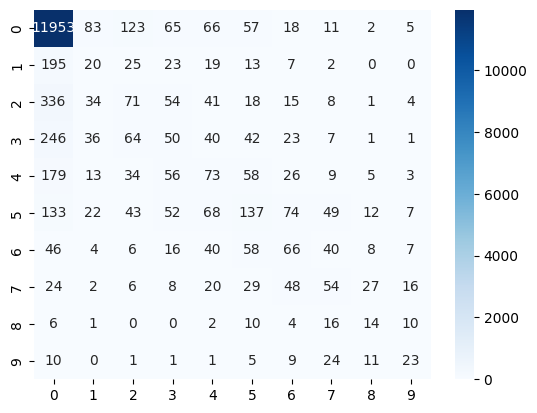

In [296]:
# SMOTEEN catboost
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
cat_SMOTEEN = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=best_cat_params['l2_leaf_reg'])
cat_SMOTEEN.fit(X_train_resampled, y_train_resampled)
y_pred = cat_SMOTEEN.predict(X_test)
model_evaluation(y_pred, y_test)

cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

0:	learn: 2.0369764	total: 3.7s	remaining: 28m 1s
1:	learn: 1.9148075	total: 7.68s	remaining: 29m
2:	learn: 1.8292998	total: 11.2s	remaining: 28m
3:	learn: 1.7577797	total: 14.4s	remaining: 27m 7s
4:	learn: 1.7105784	total: 17.7s	remaining: 26m 36s
5:	learn: 1.6607198	total: 21.1s	remaining: 26m 15s
6:	learn: 1.6251104	total: 24.3s	remaining: 25m 54s
7:	learn: 1.5894088	total: 27.9s	remaining: 25m 59s
8:	learn: 1.5585879	total: 31.2s	remaining: 25m 45s
9:	learn: 1.5349442	total: 34.4s	remaining: 25m 30s
10:	learn: 1.4984437	total: 38.1s	remaining: 25m 36s
11:	learn: 1.4771313	total: 41.2s	remaining: 25m 19s
12:	learn: 1.4538008	total: 44.5s	remaining: 25m 14s
13:	learn: 1.4168723	total: 48.3s	remaining: 25m 22s
14:	learn: 1.3990882	total: 51.5s	remaining: 25m 11s
15:	learn: 1.3657158	total: 55.2s	remaining: 25m 15s
16:	learn: 1.3507357	total: 58.4s	remaining: 25m 3s
17:	learn: 1.3336698	total: 1m 1s	remaining: 24m 59s
18:	learn: 1.3080172	total: 1m 5s	remaining: 24m 57s
19:	learn: 1.29

<Axes: >

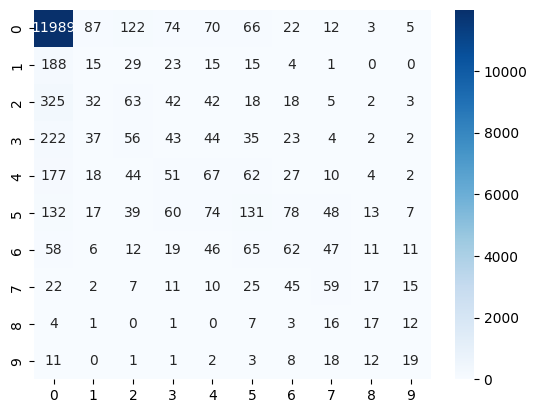

In [297]:
# SMOTEEN catboost
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_smotenn, y_train_smotenn = smote_enn.fit_resample(X_train, y_train)
cat_SMOTEEN_10 = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg=10)
cat_SMOTEEN_10.fit(X_train_resampled, y_train_resampled)
y_pred = cat_SMOTEEN_10.predict(X_test)
model_evaluation(y_pred, y_test)

cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [114]:
cat_ensemble_df = make_submission(cat_ensemble)

C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3061492177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3061492177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3061492177.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [42]:
cat_ensemble_df.to_csv('cat_ensemble.csv',index=False)

In [24]:
# SMOTE catboost regularization hyperparameter tuning
'''
reg = 20 is best 
'''

import optuna

def objective(trial):
    smote_enn = SMOTEENN(random_state=42)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 5, 30)
    cat = CatBoostClassifier(iterations=best_cat_params['iterations'], depth=best_cat_params['depth'], learning_rate=best_cat_params['learning_rate'],l2_leaf_reg = l2_leaf_reg)
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)
    # Fit the model
    cat.fit(X_train_resampled, y_train_resampled)
    
    # Predict the validation set results
    y_pred = cat.predict(X_val)
    
    # Calculate the score using your custom function
    score = clf_eval(y_pred, y_val)
    
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10) 

trial = study.best_trial

print('Score: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-06-23 03:34:30,726] A new study created in memory with name: no-name-da81e086-2658-462b-8e4b-c0f7c403308e


0:	learn: 2.0475533	total: 3.39s	remaining: 25m 39s
1:	learn: 1.9271682	total: 6.92s	remaining: 26m 8s
2:	learn: 1.8429966	total: 10.4s	remaining: 26m 8s
3:	learn: 1.7795927	total: 13.6s	remaining: 25m 39s
4:	learn: 1.7283479	total: 17s	remaining: 25m 26s
5:	learn: 1.6745289	total: 20.6s	remaining: 25m 39s
6:	learn: 1.6307653	total: 23.8s	remaining: 25m 22s
7:	learn: 1.5883111	total: 27.5s	remaining: 25m 34s
8:	learn: 1.5611252	total: 30.6s	remaining: 25m 16s
9:	learn: 1.5394913	total: 33.7s	remaining: 24m 59s
10:	learn: 1.5163870	total: 36.7s	remaining: 24m 42s
11:	learn: 1.4974653	total: 40.1s	remaining: 24m 41s
12:	learn: 1.4751863	total: 43.6s	remaining: 24m 42s
13:	learn: 1.4521278	total: 47s	remaining: 24m 41s
14:	learn: 1.4290648	total: 50.5s	remaining: 24m 40s
15:	learn: 1.4102242	total: 53.9s	remaining: 24m 38s
16:	learn: 1.3811580	total: 58.1s	remaining: 24m 56s
17:	learn: 1.3578582	total: 1m 1s	remaining: 24m 56s
18:	learn: 1.3442090	total: 1m 4s	remaining: 24m 51s
19:	learn

[I 2024-06-23 04:09:54,520] Trial 0 finished with value: 0.14301801801801803 and parameters: {'l2_leaf_reg': 20}. Best is trial 0 with value: 0.14301801801801803.


0:	learn: 2.0345207	total: 3.39s	remaining: 25m 39s
1:	learn: 1.9081169	total: 6.75s	remaining: 25m 29s
2:	learn: 1.8225380	total: 10.2s	remaining: 25m 34s
3:	learn: 1.7538085	total: 13.6s	remaining: 25m 38s
4:	learn: 1.7013870	total: 17.1s	remaining: 25m 42s
5:	learn: 1.6487506	total: 20.6s	remaining: 25m 41s
6:	learn: 1.6094463	total: 23.9s	remaining: 25m 28s
7:	learn: 1.5678942	total: 27.6s	remaining: 25m 43s
8:	learn: 1.5423146	total: 30.8s	remaining: 25m 27s
9:	learn: 1.5150475	total: 34.3s	remaining: 25m 24s
10:	learn: 1.4793530	total: 37.9s	remaining: 25m 28s
11:	learn: 1.4590027	total: 41.4s	remaining: 25m 29s
12:	learn: 1.4440726	total: 44.7s	remaining: 25m 18s
13:	learn: 1.4175517	total: 48.1s	remaining: 25m 14s
14:	learn: 1.3950376	total: 51.7s	remaining: 25m 17s
15:	learn: 1.3579980	total: 55.9s	remaining: 25m 33s
16:	learn: 1.3436343	total: 59s	remaining: 25m 21s
17:	learn: 1.3184827	total: 1m 3s	remaining: 25m 31s
18:	learn: 1.3055673	total: 1m 6s	remaining: 25m 28s
19:	l

[I 2024-06-23 04:45:32,677] Trial 1 finished with value: 0.14367487120778477 and parameters: {'l2_leaf_reg': 8}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0369764	total: 3.29s	remaining: 24m 53s
1:	learn: 1.9148075	total: 6.63s	remaining: 25m 1s
2:	learn: 1.8292998	total: 9.94s	remaining: 24m 57s
3:	learn: 1.7577797	total: 13.2s	remaining: 24m 52s
4:	learn: 1.7105784	total: 16.7s	remaining: 25m 5s
5:	learn: 1.6607198	total: 20.2s	remaining: 25m 8s
6:	learn: 1.6251104	total: 23.4s	remaining: 25m
7:	learn: 1.5894088	total: 27s	remaining: 25m 7s
8:	learn: 1.5585879	total: 30.5s	remaining: 25m 11s
9:	learn: 1.5349442	total: 34s	remaining: 25m 12s
10:	learn: 1.4984437	total: 37.8s	remaining: 25m 27s
11:	learn: 1.4771313	total: 41.4s	remaining: 25m 27s
12:	learn: 1.4538008	total: 44.9s	remaining: 25m 24s
13:	learn: 1.4168723	total: 48.7s	remaining: 25m 34s
14:	learn: 1.3990882	total: 52.2s	remaining: 25m 29s
15:	learn: 1.3657158	total: 56s	remaining: 25m 36s
16:	learn: 1.3507357	total: 59.2s	remaining: 25m 24s
17:	learn: 1.3336698	total: 1m 2s	remaining: 25m 18s
18:	learn: 1.3080172	total: 1m 6s	remaining: 25m 21s
19:	learn: 1.2915

[I 2024-06-23 05:20:53,811] Trial 2 finished with value: 0.1353811149032992 and parameters: {'l2_leaf_reg': 10}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0392919	total: 3.25s	remaining: 24m 34s
1:	learn: 1.9175148	total: 6.71s	remaining: 25m 20s
2:	learn: 1.8321356	total: 10s	remaining: 25m 11s
3:	learn: 1.7652467	total: 13.3s	remaining: 25m 2s
4:	learn: 1.7168613	total: 16.5s	remaining: 24m 48s
5:	learn: 1.6724418	total: 20.2s	remaining: 25m 13s
6:	learn: 1.6379591	total: 23.7s	remaining: 25m 13s
7:	learn: 1.5890390	total: 27.5s	remaining: 25m 38s
8:	learn: 1.5622861	total: 30.7s	remaining: 25m 19s
9:	learn: 1.5191196	total: 34.5s	remaining: 25m 34s
10:	learn: 1.4879723	total: 38.2s	remaining: 25m 40s
11:	learn: 1.4632265	total: 41.7s	remaining: 25m 38s
12:	learn: 1.4290954	total: 45.7s	remaining: 25m 55s
13:	learn: 1.4001510	total: 49.3s	remaining: 25m 52s
14:	learn: 1.3791494	total: 52.7s	remaining: 25m 47s
15:	learn: 1.3551869	total: 56.3s	remaining: 25m 44s
16:	learn: 1.3241793	total: 1m	remaining: 25m 53s
17:	learn: 1.3131157	total: 1m 3s	remaining: 25m 44s
18:	learn: 1.3030883	total: 1m 6s	remaining: 25m 29s
19:	learn

[I 2024-06-23 05:56:16,975] Trial 3 finished with value: 0.14156541395874542 and parameters: {'l2_leaf_reg': 12}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0538611	total: 3.36s	remaining: 25m 26s
1:	learn: 1.9345631	total: 6.64s	remaining: 25m 5s
2:	learn: 1.8517289	total: 10.3s	remaining: 25m 47s
3:	learn: 1.7834048	total: 13.9s	remaining: 26m 4s
4:	learn: 1.7323121	total: 17.1s	remaining: 25m 35s
5:	learn: 1.6890862	total: 20.3s	remaining: 25m 20s
6:	learn: 1.6408524	total: 24s	remaining: 25m 35s
7:	learn: 1.6111375	total: 27.4s	remaining: 25m 29s
8:	learn: 1.5813792	total: 30.6s	remaining: 25m 18s
9:	learn: 1.5566366	total: 34.2s	remaining: 25m 21s
10:	learn: 1.5270810	total: 37.7s	remaining: 25m 23s
11:	learn: 1.5037321	total: 41s	remaining: 25m 15s
12:	learn: 1.4823884	total: 44.4s	remaining: 25m 9s
13:	learn: 1.4651282	total: 47.6s	remaining: 24m 58s
14:	learn: 1.4383029	total: 51.4s	remaining: 25m 9s
15:	learn: 1.4218403	total: 55.1s	remaining: 25m 12s
16:	learn: 1.4004145	total: 58.9s	remaining: 25m 17s
17:	learn: 1.3840938	total: 1m 2s	remaining: 25m 9s
18:	learn: 1.3611794	total: 1m 5s	remaining: 25m 12s
19:	learn: 1

[I 2024-06-23 06:31:37,750] Trial 4 finished with value: 0.13606010016694492 and parameters: {'l2_leaf_reg': 27}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0456113	total: 3.33s	remaining: 25m 11s
1:	learn: 1.9248971	total: 6.65s	remaining: 25m 6s
2:	learn: 1.8406501	total: 9.95s	remaining: 24m 58s
3:	learn: 1.7771509	total: 13.2s	remaining: 24m 50s
4:	learn: 1.7257188	total: 16.5s	remaining: 24m 49s
5:	learn: 1.6714105	total: 20.4s	remaining: 25m 23s
6:	learn: 1.6273951	total: 23.7s	remaining: 25m 16s
7:	learn: 1.5844856	total: 27.5s	remaining: 25m 33s
8:	learn: 1.5571589	total: 30.7s	remaining: 25m 19s
9:	learn: 1.5353829	total: 33.8s	remaining: 25m 4s
10:	learn: 1.5122145	total: 37.1s	remaining: 24m 56s
11:	learn: 1.4930958	total: 40.6s	remaining: 24m 58s
12:	learn: 1.4706510	total: 44s	remaining: 24m 57s
13:	learn: 1.4486556	total: 47.4s	remaining: 24m 53s
14:	learn: 1.4253975	total: 51s	remaining: 24m 55s
15:	learn: 1.4064934	total: 54.3s	remaining: 24m 50s
16:	learn: 1.3877819	total: 57.9s	remaining: 24m 50s
17:	learn: 1.3683120	total: 1m 1s	remaining: 24m 58s
18:	learn: 1.3449417	total: 1m 5s	remaining: 25m 12s
19:	learn

[I 2024-06-23 07:07:06,337] Trial 5 finished with value: 0.13971830985915493 and parameters: {'l2_leaf_reg': 18}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0512421	total: 3.42s	remaining: 25m 53s
1:	learn: 1.9314890	total: 6.71s	remaining: 25m 19s
2:	learn: 1.8465752	total: 10.1s	remaining: 25m 18s
3:	learn: 1.7810305	total: 13.2s	remaining: 24m 53s
4:	learn: 1.7323564	total: 16.4s	remaining: 24m 39s
5:	learn: 1.6896990	total: 19.6s	remaining: 24m 26s
6:	learn: 1.6477571	total: 22.9s	remaining: 24m 26s
7:	learn: 1.6108240	total: 26.5s	remaining: 24m 40s
8:	learn: 1.5827353	total: 29.6s	remaining: 24m 27s
9:	learn: 1.5575243	total: 32.7s	remaining: 24m 14s
10:	learn: 1.5209480	total: 36.6s	remaining: 24m 35s
11:	learn: 1.4966307	total: 40.1s	remaining: 24m 41s
12:	learn: 1.4774557	total: 43.5s	remaining: 24m 39s
13:	learn: 1.4566886	total: 47s	remaining: 24m 41s
14:	learn: 1.4276382	total: 50.9s	remaining: 24m 52s
15:	learn: 1.4097383	total: 54.1s	remaining: 24m 43s
16:	learn: 1.3836253	total: 57.9s	remaining: 24m 51s
17:	learn: 1.3678302	total: 1m 1s	remaining: 24m 42s
18:	learn: 1.3484604	total: 1m 4s	remaining: 24m 39s
19:	l

[I 2024-06-23 07:42:30,045] Trial 6 finished with value: 0.13633818589025756 and parameters: {'l2_leaf_reg': 24}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0530009	total: 3.34s	remaining: 25m 16s
1:	learn: 1.9335528	total: 6.68s	remaining: 25m 12s
2:	learn: 1.8506749	total: 9.97s	remaining: 25m 2s
3:	learn: 1.7822633	total: 13.1s	remaining: 24m 41s
4:	learn: 1.7311162	total: 16.6s	remaining: 24m 54s
5:	learn: 1.6878416	total: 19.9s	remaining: 24m 45s
6:	learn: 1.6393705	total: 23.5s	remaining: 25m 5s
7:	learn: 1.6096132	total: 26.8s	remaining: 24m 58s
8:	learn: 1.5852060	total: 30s	remaining: 24m 48s
9:	learn: 1.5561930	total: 33.5s	remaining: 24m 51s
10:	learn: 1.5250132	total: 37.4s	remaining: 25m 10s
11:	learn: 1.4975644	total: 40.7s	remaining: 25m 3s
12:	learn: 1.4806461	total: 43.9s	remaining: 24m 51s
13:	learn: 1.4581974	total: 47.1s	remaining: 24m 43s
14:	learn: 1.4387348	total: 50.5s	remaining: 24m 39s
15:	learn: 1.4208281	total: 53.6s	remaining: 24m 31s
16:	learn: 1.3940579	total: 57.7s	remaining: 24m 47s
17:	learn: 1.3715916	total: 1m 1s	remaining: 24m 55s
18:	learn: 1.3617766	total: 1m 4s	remaining: 24m 43s
19:	lear

[I 2024-06-23 08:18:13,865] Trial 7 finished with value: 0.14046822742474915 and parameters: {'l2_leaf_reg': 26}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0357680	total: 3.41s	remaining: 25m 47s
1:	learn: 1.9096850	total: 6.71s	remaining: 25m 21s
2:	learn: 1.8242701	total: 10.2s	remaining: 25m 40s
3:	learn: 1.7557641	total: 13.6s	remaining: 25m 36s
4:	learn: 1.7034479	total: 16.9s	remaining: 25m 16s
5:	learn: 1.6510850	total: 20.2s	remaining: 25m 10s
6:	learn: 1.6119296	total: 23.3s	remaining: 24m 51s
7:	learn: 1.5692355	total: 27.2s	remaining: 25m 20s
8:	learn: 1.5390882	total: 30.5s	remaining: 25m 11s
9:	learn: 1.5099048	total: 33.8s	remaining: 25m 3s
10:	learn: 1.4830885	total: 37.2s	remaining: 25m
11:	learn: 1.4662843	total: 40.3s	remaining: 24m 46s
12:	learn: 1.4393631	total: 43.8s	remaining: 24m 48s
13:	learn: 1.4133701	total: 47.3s	remaining: 24m 50s
14:	learn: 1.3955340	total: 50.6s	remaining: 24m 43s
15:	learn: 1.3820594	total: 53.8s	remaining: 24m 35s
16:	learn: 1.3505283	total: 57.8s	remaining: 24m 49s
17:	learn: 1.3270862	total: 1m 1s	remaining: 24m 50s
18:	learn: 1.3079682	total: 1m 5s	remaining: 24m 54s
19:	lear

[I 2024-06-23 08:53:56,796] Trial 8 finished with value: 0.1416738074835761 and parameters: {'l2_leaf_reg': 9}. Best is trial 1 with value: 0.14367487120778477.


0:	learn: 2.0345207	total: 3.51s	remaining: 26m 35s
1:	learn: 1.9081169	total: 6.77s	remaining: 25m 33s
2:	learn: 1.8225380	total: 9.97s	remaining: 25m 2s
3:	learn: 1.7538085	total: 13.4s	remaining: 25m 10s
4:	learn: 1.7013870	total: 16.8s	remaining: 25m 16s
5:	learn: 1.6487506	total: 20.2s	remaining: 25m 12s
6:	learn: 1.6094463	total: 23.3s	remaining: 24m 53s
7:	learn: 1.5678942	total: 27s	remaining: 25m 9s
8:	learn: 1.5423146	total: 30.1s	remaining: 24m 49s
9:	learn: 1.5150475	total: 34s	remaining: 25m 11s
10:	learn: 1.4793530	total: 37.5s	remaining: 25m 14s
11:	learn: 1.4590027	total: 40.7s	remaining: 25m 2s
12:	learn: 1.4440726	total: 43.8s	remaining: 24m 47s
13:	learn: 1.4175517	total: 47.1s	remaining: 24m 43s
14:	learn: 1.3950376	total: 50.7s	remaining: 24m 48s
15:	learn: 1.3579980	total: 54.7s	remaining: 24m 59s
16:	learn: 1.3436343	total: 57.8s	remaining: 24m 49s
17:	learn: 1.3184827	total: 1m 1s	remaining: 24m 51s
18:	learn: 1.3055673	total: 1m 4s	remaining: 24m 41s
19:	learn:

[I 2024-06-23 09:29:37,539] Trial 9 finished with value: 0.14367487120778477 and parameters: {'l2_leaf_reg': 8}. Best is trial 1 with value: 0.14367487120778477.


Score: 0.14367487120778477
Best hyperparameters: {'l2_leaf_reg': 8}


In [37]:
cat_SMOTE_df.to_csv('cat_SMOTE.csv') # 

In [38]:
cat_SMOTEEN_df.to_csv('cat_SMOTEEN.csv')

In [280]:
cat.fit(X_train,y_train)

0:	learn: 1.0546204	total: 1.04s	remaining: 7m 54s
1:	learn: 0.8888118	total: 2.21s	remaining: 8m 20s
2:	learn: 0.7828820	total: 3.18s	remaining: 7m 58s


KeyboardInterrupt: 

In [314]:
proba1 = cat_SMOTE_10.predict_proba(X_test)
proba2 = cat_SMOTE.predict_proba(X_test)
proba3 = cat_SMOTEEN_10.predict_proba(X_test)
proba4 = cat_SMOTEEN.predict_proba(X_test)
proba5 = cat.predict_proba(X_test)

Accuracy: 0.8475975491776846
Precision: 0.8265781444766875
Recall: 0.8475975491776846


0.15304659498207884

<Axes: >

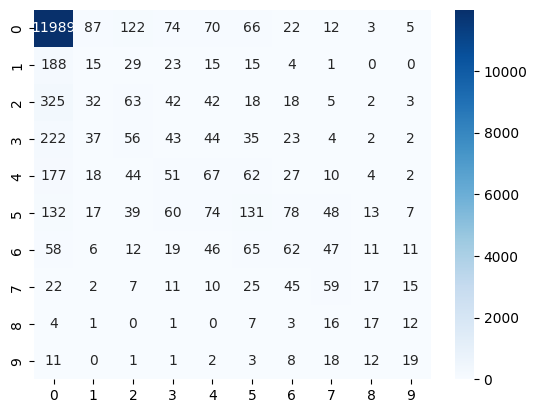

In [316]:
cm = confusion_matrix(y_pred,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [419]:
proba1 = cat_SMOTE_10.predict_proba(X_test)
proba2 = cat_SMOTE.predict_proba(X_test)
proba3 = cat_SMOTEEN_10.predict_proba(X_test)
proba4 = cat_SMOTEEN.predict_proba(X_test)
proba5 = cat.predict_proba(X_test)

In [426]:
proba = proba1+proba3+proba5
predict = np.argmax(proba, axis=1)
# Evaluate the model
model_evaluation(predict,y_test)

Accuracy: 0.8506933247339568
Precision: 0.8238069921599934
Recall: 0.8506933247339568


0.1498347410943812

<Axes: >

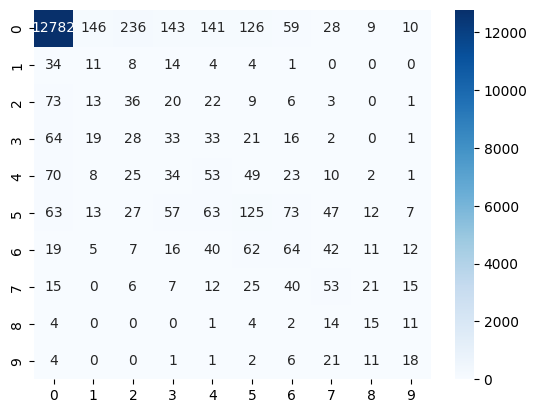

In [428]:
cm = confusion_matrix(predict,y_test)
import seaborn as sns
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [ ]:
SMOTE_df = pd.read_csv('240183_0.124_SMOTE.csv')
SMOTEEN_df = pd.read_csv('240183_0.122_SMOTEEN.csv')

In [ ]:
proba = proba1+proba2+proba3+proba4+proba5
predict = np.argmax(proba, axis=1)
# Evaluate the model
model_evaluation(predict,y_test)

In [424]:
# Combine probabilities (average or maximum confidence)
# Example of averaging probabilities
proba = (proba1*0.09 + proba2*0.09 + proba3*0.182 + proba4*0.273 + proba5*0.364)/5
# Predict class with highest probability
predict = np.argmax(proba, axis=1)

# Evaluate the model
model_evaluation(predict,y_test)

Accuracy: 0.8475975491776846
Precision: 0.8265781444766875
Recall: 0.8475975491776846


0.15304659498207884

<Axes: >

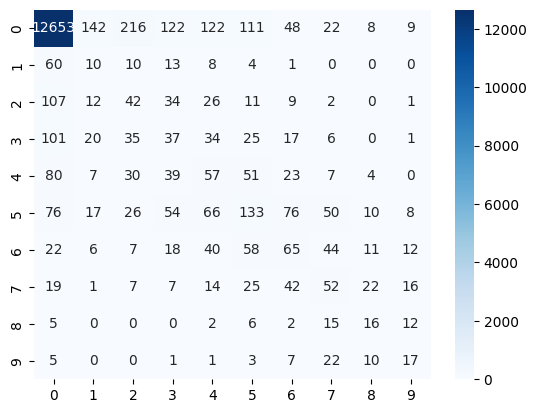

In [423]:
cm = confusion_matrix(predict,y_test)
sns.heatmap(cm,annot=True,cmap ='Blues',fmt='d')

In [307]:
from itertools import product

def weighted_average(probabilities, weights):
    weighted_probabilities = np.tensordot(weights, probabilities, axes=(0, 0))
    weighted_average_probabilities = weighted_probabilities / np.sum(weights)
    return weighted_average_probabilities
weight_combinations = list(product(range(1, 5), repeat=5))
weight_combinations = [tuple(np.array(w) / np.sum(w)) for w in weight_combinations]
probabilities = [proba1, proba2, proba3, proba4, proba5]

In [309]:
best_accuracy = 0
best_weights = None

for weights in weight_combinations:
    combined_proba = weighted_average(probabilities, weights)
    predictions = np.argmax(combined_proba, axis=1)
    accuracy = model_evaluation(predictions, y_test)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

print(f'Best accuracy: {best_accuracy}')
print(f'Best weights: {best_weights}')

Accuracy: 0.8437278297323444
Precision: 0.8268654271788387
Recall: 0.8437278297323444
Accuracy: 0.8508223153821348
Precision: 0.8239452436837663
Recall: 0.8508223153821348
Accuracy: 0.8535311189938729
Precision: 0.8210845401205854
Recall: 0.8535311189938729
Accuracy: 0.854627539503386
Precision: 0.8177805384209754
Recall: 0.854627539503386
Accuracy: 0.836955820702999
Precision: 0.8303161599242057
Recall: 0.836955820702999
Accuracy: 0.8450177362141245
Precision: 0.8263187985135878
Recall: 0.8450177362141245
Accuracy: 0.8504353434376007
Precision: 0.8237961356507224
Recall: 0.8504353434376007
Accuracy: 0.852950661077072
Precision: 0.821322988328305
Recall: 0.852950661077072
Accuracy: 0.8321831667204128
Precision: 0.8333362415315283
Recall: 0.8321831667204128
Accuracy: 0.8402450822315383
Precision: 0.829482248609363
Recall: 0.8402450822315383
Accuracy: 0.8460496613995485
Precision: 0.8261611680616924
Recall: 0.8460496613995485
Accuracy: 0.8497258948726217
Precision: 0.8236909930991507
Rec

In [394]:
def ensemble_submission(model1,model2,model3,model4,model5):
    test_df = pd.read_csv('rainfall_test.csv')
    test_df.columns = test_df.columns.str.replace('rainfall_test.', '', regex=False)
    data_df = pd.read_csv('sequential.csv')
    columns_drop = ['label','vv','Unnamed: 0']
    data_df = data_df.drop(columns = columns_drop)
    answer_df = test_df[data_df.columns]
    le_ef_month = LabelEncoder()
    answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
    answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
    answer_df['ef_day'] = le_ef_month.fit_transform(answer_df['ef_day'])
    answer_df['ef_hour'] = le_ef_month.fit_transform(answer_df['ef_hour'])
    answer_df['v01'] = answer_df['v01']/100
    answer_df['v02'] = answer_df['v02']/100
    answer_df['v03'] = answer_df['v03']/100
    answer_df['v04'] = answer_df['v04']/100
    answer_df['v05'] = answer_df['v05']/100
    answer_df['v06'] = answer_df['v06']/100
    answer_df['v07'] = answer_df['v07']/100
    answer_df['v08'] = answer_df['v08']/100
    answer_df['v09'] = answer_df['v09']/100
    prob_column = ['v01','v02','v03','v04','v05','v06','v07','v08','v09','dh']
    index_column = ['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
    answer_agg = answer_df.groupby(index_column)[prob_column].agg(['mean', 'std', 'min', 'max', 'first'])
    answer_agg.columns = ['_'.join(x) for x in answer_agg.columns]
    answer_first = answer_df.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']).head(1)
    answer_agg.index= answer_first.index
    answer_agg = answer_agg.fillna(0)
    answer_agg['diff1']=answer_agg['v01_first']-answer_agg['v02_first']
    answer_agg['diff2']=answer_agg['v02_first']-answer_agg['v03_first']
    answer_agg['diff3']=answer_agg['v03_first']-answer_agg['v04_first']
    answer_agg['diff4']=answer_agg['v04_first']-answer_agg['v05_first']
    answer_agg['diff5']=answer_agg['v05_first']-answer_agg['v06_first']
    answer_agg['diff6']=answer_agg['v06_first']-answer_agg['v07_first']
    answer_agg['diff7']=answer_agg['v07_first']-answer_agg['v08_first']
    answer_agg['diff8']=answer_agg['v08_first']-answer_agg['v09_first']
    answer_agg['ef_month'] = answer_first['ef_month']
    answer_agg['ef_day'] = answer_first['ef_day']
    answer_agg['ef_hour'] = answer_first['ef_hour']
    answer_agg = answer_agg[X.columns]
    
    pred1 = model1.predict_proba(answer_agg)
    pred2 = model2.predict_proba(answer_agg)
    pred3 = model3.predict_proba(answer_agg)
    pred4 = model4.predict_proba(answer_agg)
    pred5 = model5.predict_proba(answer_agg)
    pred = (pred1 + pred2 + pred3 + pred4 + pred5)/5

    answer = np.argmax(pred, axis=1)

    answer_agg['class_interval']=answer
    answer_df['class_interval'] = answer_df.index.map(answer_agg['class_interval'])
    answer_df['class_interval'] = answer_df.groupby(['stn4contest','ef_year','ef_month','ef_day','ef_hour'])['class_interval'].fillna(method='ffill')
    test_df['class_interval']=answer_df['class_interval']
    return test_df

In [395]:
ensemble_5_avg = ensemble_submission(cat_SMOTE_10,cat_SMOTE,cat_SMOTEEN_10,cat_SMOTEEN,cat)


C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3388018240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_month'] = le_ef_month.fit_transform(answer_df['ef_month'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3388018240.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  answer_df['ef_year'] = le_ef_month.fit_transform(answer_df['ef_year'])
C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3388018240.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [399]:
ensemble_5_avg['class_interval'] = ensemble_5_avg['class_interval'].astype(int)
ensemble_5_avg.columns = [
    'rainfall_test.fc_year', 'rainfall_test.fc_month', 'rainfall_test.fc_day', 'rainfall_test.fc_hour', 
    'rainfall_test.stn4contest', 'rainfall_test.dh', 'rainfall_test.ef_year', 'rainfall_test.ef_month', 
    'rainfall_test.ef_day', 'rainfall_test.ef_hour', 'rainfall_test.v01', 'rainfall_test.v02', 
    'rainfall_test.v03', 'rainfall_test.v04', 'rainfall_test.v05', 'rainfall_test.v06', 
    'rainfall_test.v07', 'rainfall_test.v08', 'rainfall_test.v09', 'rainfall_test.class_interval'
]

In [418]:
ensemble_5_avg.to_csv('ensemble_5_avg.csv',index=False)

In [441]:
ensemble_5_avg

rainfall_test.fc_year  rainfall_test.fc_month  rainfall_test.fc_day  \
0                          D                       5                     1   
1                          D                       5                     1   
2                          D                       5                     1   
3                          D                       5                     1   
4                          D                       5                     1   
...                      ...                     ...                   ...   
121995                     D                       9                    30   
121996                     D                       9                    30   
121997                     D                       9                    30   
121998                     D                       9                    30   
121999                     D                       9                    30   

        rainfall_test.fc_hour rainfall_test.stn4contest  rainfall_test.dh  \
0                           9                    STN031                 3   
1                           9                    STN031                 6   
2                           9                    STN031                 9   
3                           9                    STN031                12   
4                           9                    STN031                15   
...                       ...                       ...               ...   
121995                     21                    STN035               228   
121996                     21                    STN035               231   
121997                     21                    STN035               234   
121998                     21                    STN035               237   
121999                     21                    STN035               240   

       rainfall_test.ef_year  rainfall_test.ef_month  rainfall_test.ef_day  \
0                          D                       5                     1   
1                          D                       5                     1   
2                          D                       5                     1   
3                          D                       5                     1   
4                          D                       5                     2   
...                      ...                     ...                   ...   
121995                     D                      10                    10   
121996                     D                      10                    10   
121997                     D                      10                    10   
121998                     D                      10                    10   
121999                     D                      10                    10   

        rainfall_test.ef_hour  rainfall_test.v01  rainfall_test.v02  \
0                          12                 68                 46   
1                          15                 83                 66   
2                          18                 17                  6   
3                          21                  0                  0   
4                           0                  0                  0   
...                       ...                ...                ...   
121995                      9                  4                  4   
121996                     12                  8                  6   
121997                     15                  8                  6   
121998                     18                 10                  8   
121999                     21                 10                  8   

        rainfall_test.v03  rainfall_test.v04  rainfall_test.v05  \
0                      13                  1                  0   
1                      26                  5                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                   

In [43]:
SMOTE_df = pd.read_csv('240183_0.124_SMOTE.csv')
SMOTEEN_df = pd.read_csv('240183_0.122_SMOTEEN.csv')

print(abc)

In [231]:
data_df = pd.read_csv('sequential.csv')

In [232]:
data_df.describe()

Unnamed: 0      ef_month        ef_day       ef_hour            dh  \
count  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06   
mean   7.279149e+05  7.181998e+00  1.577465e+01  1.051332e+01  1.214129e+02   
std    4.205969e+05  1.455392e+00  8.856216e+00  6.874927e+00  6.925929e+01   
min    0.000000e+00  5.000000e+00  1.000000e+00  0.000000e+00  3.000000e+00   
25%    3.636492e+05  6.000000e+00  8.000000e+00  6.000000e+00  6.000000e+01   
50%    7.275665e+05  7.000000e+00  1.600000e+01  1.200000e+01  1.200000e+02   
75%    1.092080e+06  8.000000e+00  2.300000e+01  1.800000e+01  1.800000e+02   
max    1.457251e+06  1.000000e+01  3.100000e+01  2.100000e+01  2.400000e+02   

                v01           v02           v03           v04           v05  \
count  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06   
mean   3.033317e-01  2.537899e-01  1.850289e-01  1.358662e-01  9.389566e-02   
std    2.924975e-01  2.699781e-01  2.307967e-01  1.964298e-01  1.596720e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    4.000000e-02  2.000000e-02  1.000000e-02  0.000000e+00  0.000000e+00   
50%    2.200000e-01  1.600000e-01  9.000000e-02  5.000000e-02  2.000000e-02   
75%    5.000000e-01  4.100000e-01  2.800000e-01  1.900000e-01  1.200000e-01   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

                v06           v07           v08           v09            vv  \
count  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06  1.448762e+06   
mean   4.643552e-02  1.909427e-02  4.379346e-03  1.393417e-03  8.557637e-01   
std    1.039962e-01  5.851269e-02  2.286693e-02  1.111090e-02  4.438466e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.000000e-02  2.000000e-02  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  9.900000e-01  2.032000e+02   

       class_interval         label  
count    1.448762e+06  1.448762e+06  
mean     6.673415e-01  1.556136e-01  
std      1.760961e+00  3.624887e-01  
min      0.000000e+00  0.000000e+00  
25%      0.000000e+00  0.000000e+00  
50%      0.000000e+00  0.000000e+00  
75%      0.000000e+00  0.000000e+00  
max      9.000000e+00  1.000000e+00

In [325]:
data = pd.DataFrame({'importance': [feature_imp[i] for i in sorted_indices]})

C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3632899259.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=data, palette=colors)
C:\Users\dochy\AppData\Local\Temp\ipykernel_1900\3632899259.py:26: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='Importance', y='Feature', data=data, palette=colors)


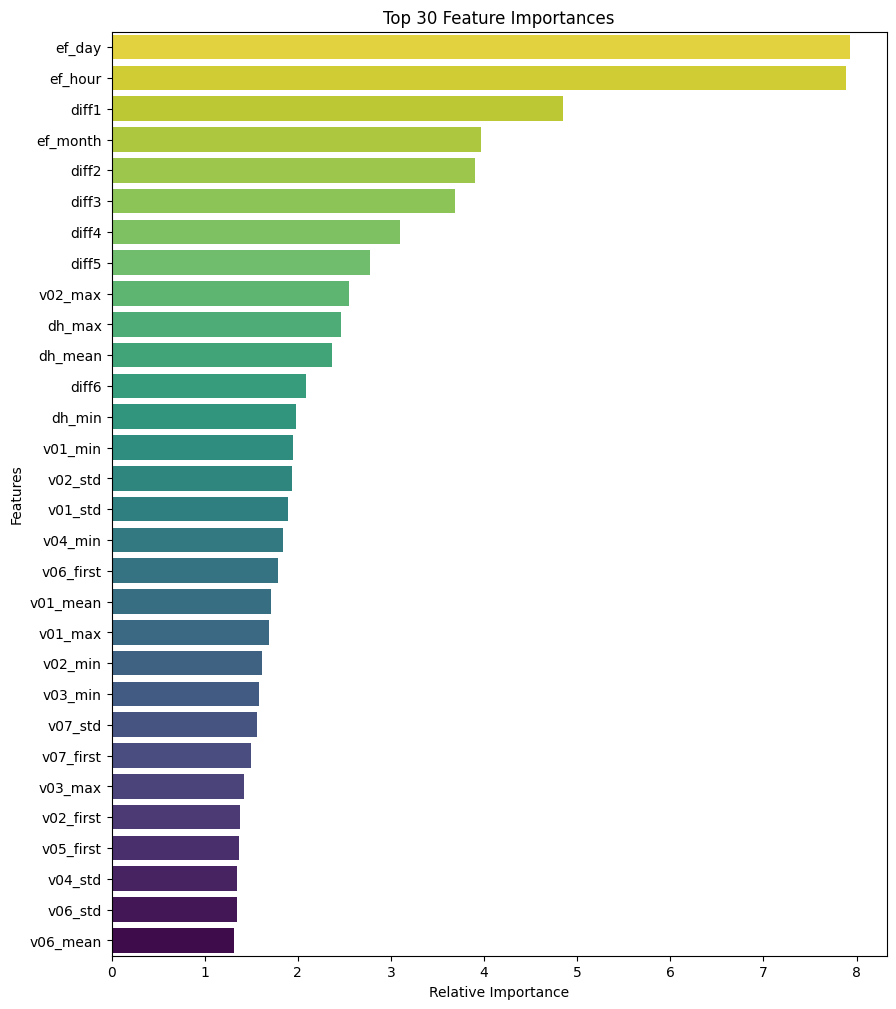

In [345]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `feature_imp` and `feature_names` are defined as in your excerpt
feature_imp = cat.get_feature_importance()
feature_names = cat.feature_names_

# Getting the top 30 sorted features and their importances
top_30_indices = sorted(range(len(feature_imp)), key=lambda k: feature_imp[k], reverse=True)[:30]
top_30_importances = [feature_imp[i] for i in top_30_indices]
top_30_names = [feature_names[i] for i in top_30_indices]

# Creating a DataFrame for easier plotting with Seaborn
import pandas as pd
data = pd.DataFrame({
    'Feature': top_30_names,
    'Importance': top_30_importances
})
data.sort_values(by='Importance', inplace=True, ascending = False)
cmap = plt.get_cmap('viridis')

colors = cmap(np.linspace(1, 0, len(data['Importance'])))

# Creating the plot
plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=data, palette=colors)
plt.title('Top 30 Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
SMOTE_df = pd.read_csv('240183_0.124_SMOTE.csv')
SMOTEEN_df = pd.read_csv('240183_0.122_SMOTEEN.csv')

In [388]:
full_df = pd.read_csv('240183_0_ensemble_full.csv')

In [392]:
full_df['rainfall_test.class_interval'] = full_df['rainfall_test.class_interval'].astype(int)

In [393]:
full_df.to_csv('240183_fulldata.csv',index=False)

In [15]:
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from graphviz import Source

In [12]:
def visualize_catboost_tree(model, tree_index, pool):
    dot_string = model.plot_tree(tree_index, pool)
    graph = Source(dot_string)
    return graph

In [58]:
graph = visualize_catboost_tree(cat,tree_index=454,pool= Pool(X_train, y_train))

In [40]:
display(graph)

In [63]:
for i in range(455):
    graph = visualize_catboost_tree(cat,tree_index=i,pool= Pool(X_train, y_train))
    svg_content = graph.pipe(format='svg').decode('utf-8')
    with open(f'output_{i}.svg', 'w') as f:
        f.write(svg_content)